In [1]:
import matplotlib.pyplot as plt     # plots
import pandas as pd                 # data processing
import numpy as np                  # number processing
import folium                       # easy maps, also interactive
from folium.features import DivIcon # needed for map labels
import glob                         # glob2
import re                           # regix package, for following three functions

# from https://nedbatchelder.com/blog/200712/human_sorting.html
# this is for the alphanum_key at the end of the initial glob data ingest 
###############################################################################
def tryint(s):
    """
    Return an int if possible, or `s` unchanged.
    """
    try:
        return int(s)
    except ValueError:
        return s

def alphanum_key(s):
    """
    Turn a string into a list of string and number chunks.
    >>> alphanum_key("z23a")
    ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def human_sort(l):
    """
    Sort a list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
###############################################################################

# INITIAL INJEST OF CSUM BUOY DATA
datlog_raw  = sorted(glob.glob('../python_code/data/B*.dat'),key=alphanum_key)
exo_raw     = sorted(glob.glob('../python_code/data/E*.dat'),key=alphanum_key)
ms3_raw     = sorted(glob.glob('../python_code/data/M*.dat'),key=alphanum_key)
ws_raw      = sorted(glob.glob('../python_code/data/W*.dat'),key=alphanum_key)
paraq1_raw  = sorted(glob.glob('../python_code/data/PAR_aqua1*.dat'),key=alphanum_key)
paraq2_raw  = sorted(glob.glob('../python_code/data/PAR_aqua2*.dat'),key=alphanum_key)
paratmo_raw = sorted(glob.glob('../python_code/data/PAR_atmo*.dat'),key=alphanum_key)

In [2]:
## DATALOGGER DATA PROCESSING
datlog_list = [] # init empty dataframe 
for x in datlog_raw:
    loop = pd.read_csv(x,
                       sep=',',
                       names=['time','record','BattV','PTemp'],
                       header=3,
                       parse_dates=[0]) 
    datlog_list.append(loop)    

dl = pd.concat(datlog_list,ignore_index=True)   # why do I need to concat again?
dl = dl.set_index('time')                       # set the time column to be the index
dl = dl.loc['2023-05-30':'2023-06-03']          # slicing dates
dl_hr = dl.resample('1H').mean()

C:\Users\Scopazzi\AppData\Local\Temp\ipykernel_25644\2169035148.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dl_hr = dl.resample('1H').mean()


In [3]:
## MET STATION DATA PROCESSING
met_list = [] # init empty dataframe 
for x in ms3_raw:
    loop = pd.read_csv(x,
                       sep=',',
                       names=["time","record","BP","RH","AirTemp","DP"],
                       header=3,
                       parse_dates=[0]) 
    met_list.append(loop)

met = pd.concat(met_list,ignore_index=True)   
met = met.set_index('time')                   # set the time column to be the index
met = met.loc['2023-05-30':'2023-06-03']      # slicing dates
met_hr = met.resample('1H').mean()
met_hhr = met.resample('30MIN').mean()

In [4]:
## WS DATA PROCESSING
ws_list = [] # init empty dataframe 
for x in ws_raw:
    loop = pd.read_csv(x,sep=',',
                       names=["time","record","fWSV1","fWSV2","fWSV3","fWSC","iWSDiag","iWSValue"],
                       header=3,
                       parse_dates=[0]) 
    ws_list.append(loop)

ws = pd.concat(ws_list,ignore_index=True) 
ws = ws.set_index('time')                   # set the time column to be the index
ws = ws.loc['2023-05-30':'2023-06-03',]     # slicing dates 
ws_2hr = ws.resample('2H').mean()
ws_hhr = ws.resample('30MIN').mean()

In [5]:
## EXO
exo_list = [] # init empty dataframe 
for x in exo_raw:
    loop = pd.read_csv(x,
                       sep=',',
                       names=["time","record","Chloro","nLFCond","Pressure",
                       "Turbidity","Temp","Cond","D_OX","Sal","TSS","VerticalPosition",
                       "Depth","D_OX2","SpCond","WiperPosition","BPower","fDOM","D_OX3",
                       "Phycoerythrin","pH","CablePower","fDOM2","ORP","TDS","pH2"],
                       header=2,
                       na_values='NaN',
                       parse_dates=[0]) 
    exo_list.append(loop)

exo    = pd.concat(exo_list,ignore_index=True)   
exo    = exo.set_index('time')                          # set the time column to be the index
exo    = exo.loc['2023-05-30':'2023-06-03']             # slicing dates I want
exo_hr = exo.astype('float').resample('1H').mean()      # but what is the astype doing really

In [6]:
## PAR
# The atmo and paraq1 sensors were swapped in the wiring during the test so the datalogger put the wrong data in the
# respective files. I've swapped them at the start of the for loop. Must UNSWAP in code when wired correctly. 

# init PAR top
aq1_list = [] # init empty dataframe 
for x in paratmo_raw: # real paraq1 data is in atmo from datalogger
    loop = pd.read_csv(x,sep=',',names=["time","record","PAR_aqua1_Den","PAR_aqua1_Tot"],
                       header=3,
                       parse_dates=[0],
                       encoding = "utf-8") 
    aq1_list.append(loop)

aq1     = pd.concat(aq1_list,ignore_index=True)       
aq1     = aq1.set_index('time')                      # set the time column to be the index
aq1     = aq1.loc['2023-05-30':'2023-06-01']         # slicing dates I want
aqtop_hr  = aq1.astype('int64').resample('1H').mean()  # but what is the astype doing really

# init PAR bottom
aq2_list = [] # init empty dataframe 
for y in paraq2_raw:
    loop = pd.read_csv(y,
                       sep=',',
                       names=["time","record","PAR_aqua2_Den","PAR_aqua2_Tot"],
                       header=3,
                       parse_dates=[0],
                       encoding = "utf-8") 
    aq2_list.append(loop)

aq2     = pd.concat(aq2_list,ignore_index=True)         
aq2     = aq2.set_index('time')                        # time for index
aq2     = aq2.loc['2023-05-30':'2023-06-01']           # slicing dates 
aqbottom_hr  = aq2.astype('int64').resample('1H').mean()    # but what is the astype doing really

# init PAR atmo
paratmo_list = [] # init empty dataframe 
for z in paraq1_raw: # real atmo data is in paraq1 from datalogger
    loop = pd.read_csv(z,
                       sep=',',
                       names=["time","record","PAR_atmo_Den","PAR_atmo_Tot"],
                       header=3,
                       parse_dates=[0],
                       encoding = "utf-8") 
    paratmo_list.append(loop)

aq3 = pd.concat(paratmo_list,ignore_index=True)        
aq3 = aq3.set_index('time')                           # set the time column to be the index
aq3 = aq3.loc['2023-05-30':'2023-06-01']              # slicing dates I want
paratmo_hr = aq3.astype('int64').resample('1H').mean()    # but what is the astype doing really

In [7]:
# The Closest National Date Buoy Center station is DPXC1
# https://www.ndbc.noaa.gov/station_history.php?station=dpxc1
# 38.056 N, 122.264 W

# May
urlmay        = 'https://www.ndbc.noaa.gov/view_text_file.php?filename=dpxc152023.txt.gz&dir=data/stdmet/May/'
davismay      = pd.read_csv(urlmay,                      # read in raw csv data
                           header=[0],                  # want line 0 for head info
                           na_values=('999.0','99.0'),  # clean data
                           skiprows=[1],                # skip row with units
                           sep='\s+')                   # seperator is a space
time          = davismay.iloc[:,0:5]                     # locate just the time columns on the left
time.columns  = ['year','month','day','hour','minute']   # rename the columns for next step
mayindex      = pd.to_datetime(time,format='stdmet')     # convert to datetime and make index
davismay      = davismay.set_index(mayindex)             # set index for May's data
davismay      = davismay.loc['2023-05-30':'2023-06-03']  # slicing dates I want
davismay.PRES = davismay.PRES[davismay.PRES < 1500]     # prior na_values didn't catch this
davismay_hhr  = davismay.resample('30MIN').mean()        # 30 min averages to make plots cleaner 

# June // same as above
urljune      = 'https://www.ndbc.noaa.gov/view_text_file.php?filename=dpxc162023.txt.gz&dir=data/stdmet/Jun/'
davisjune    = pd.read_csv(urljune,
                           header=[0],
                           na_values=('999.0','99.0'),
                           skiprows=[1],
                           sep='\s+')  
time          = davisjune.iloc[:,0:5]
time.columns  = ['year','month','day','hour','minute']
juneindex     = pd.to_datetime(time,format='stdmet') 
davisjune     = davisjune.set_index(juneindex)
davisjune     = davisjune.loc['2023-05-30':'2023-06-03']      
davisjune.PRES = davisjune.PRES[davisjune.PRES < 1500]
davisjune_hhr = davisjune.resample('30MIN').mean()
davisjune.head(1)

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
2023-06-01,2023,6,1,0,0,213.0,8.5,9.8,NaN,NaN,NaN,NaN,1009.7,16.1,NaN,NaN,NaN,NaN


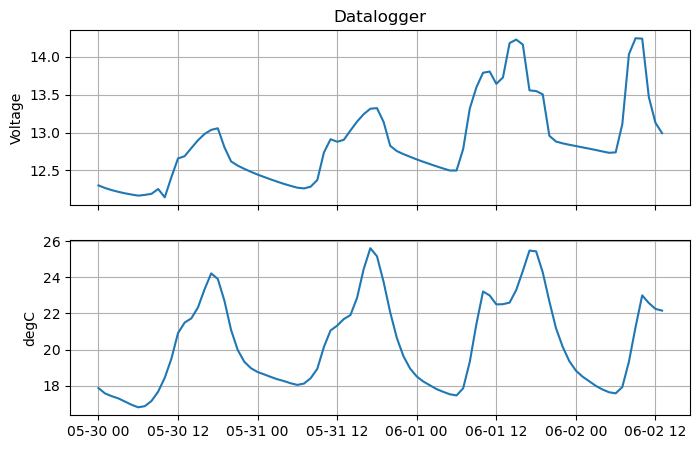

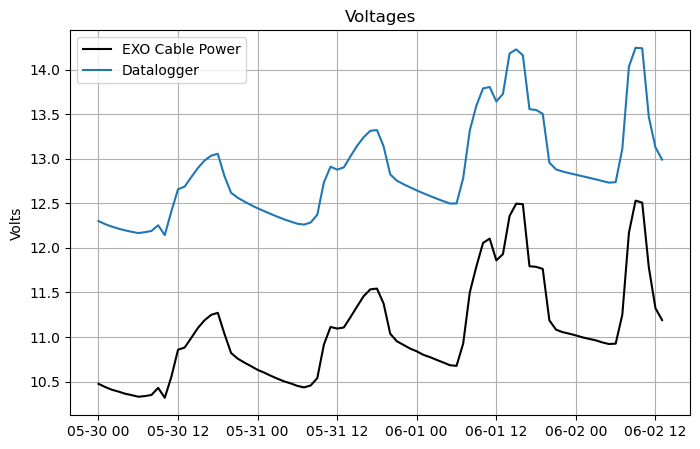

In [8]:
fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(8,5),sharex=True)
ax[0].set_title('Datalogger')

ax[0].plot(dl_hr.index,dl_hr.BattV)
ax[0].set_ylabel('Voltage')
ax[0].grid()

ax[1].plot(dl_hr.index,dl_hr.PTemp)
ax[1].set_ylabel('degC')
ax[1].grid()

#####################
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(exo_hr.index,exo_hr.CablePower,label='EXO Cable Power',color='black')
ax.plot(dl_hr.index,dl_hr.BattV,label='Datalogger')
ax.legend()
ax.set_ylabel('Volts')
ax.set_title('Voltages')
ax.grid();


# fig,ax=plt.subplots(figsize=(8,5))
# ax.plot(dl.index,dl.BattV,label='Battery Voltage')
# ax.set_ylabel('Voltage')
# ax2=ax.twinx()
# ax2.plot(dl.index,dl.PTemp,label='Panel Temp',color='red')
# ax2.set_ylabel('degC')
# ax.legend()
# ax2.legend()

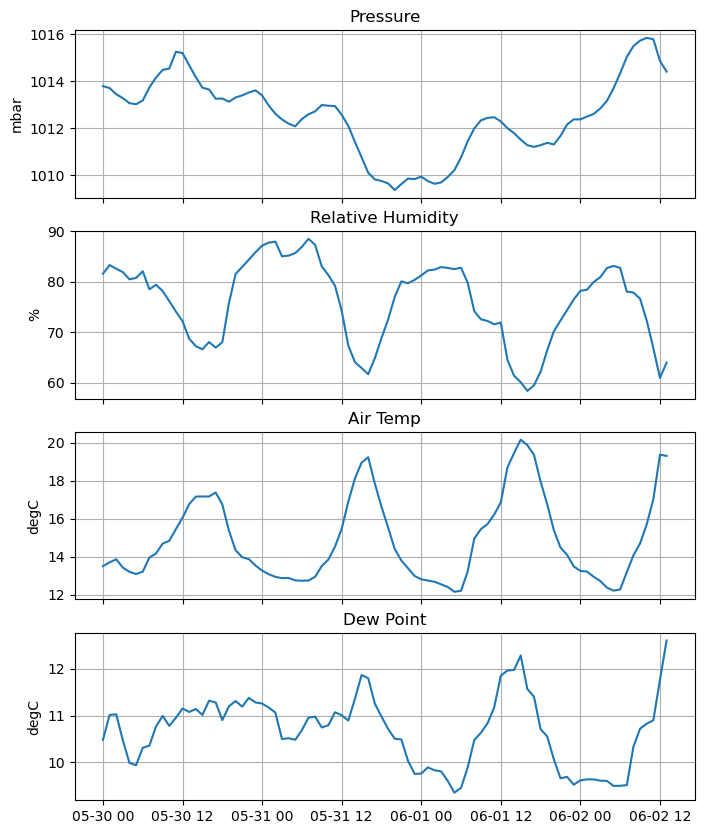

In [9]:
fig,ax=plt.subplots(ncols=1,nrows=4,figsize=(8,10),sharex=True)

ax[0].plot(met_hr.index,met_hr.BP)
ax[0].set_ylabel('mbar')
ax[0].set_title('Pressure')

ax[1].plot(met_hr.index,met_hr.RH)
ax[1].set_ylabel('%')
ax[1].set_title('Relative Humidity')

ax[2].plot(met_hr.index,met_hr.AirTemp)
ax[2].set_ylabel('degC')
ax[2].set_title('Air Temp')

ax[3].plot(met_hr.index,met_hr.DP)
ax[3].set_ylabel('degC')
ax[3].set_title('Dew Point')

ax[0].grid(),ax[1].grid(),ax[2].grid(),ax[3].grid();

# THIS IS JUST TO SEE THE DIFFERENCE BETWEEN THE HR BIN AVERAGES AND NOT 
# here to see the diff to show people

# fig,ax=plt.subplots(ncols=1,nrows=4,figsize=(8,10),sharex=ax[0])

# ax[0].plot(dl.index,dl.BP)
# ax[0].set_ylabel('mbar')
# ax[0].set_title('Pressure')

# ax[1].plot(dl.index,dl.RH)
# ax[1].set_ylabel('%')
# ax[1].set_title('Relative Humidity')

# ax[2].plot(dl.index,dl.AirTemp)
# ax[2].set_ylabel('degC')
# ax[2].set_title('Air Temp')

# ax[3].plot(dl.index,dl.DP)
# ax[3].set_ylabel('degC')
# ax[3].set_title('Dew Point')

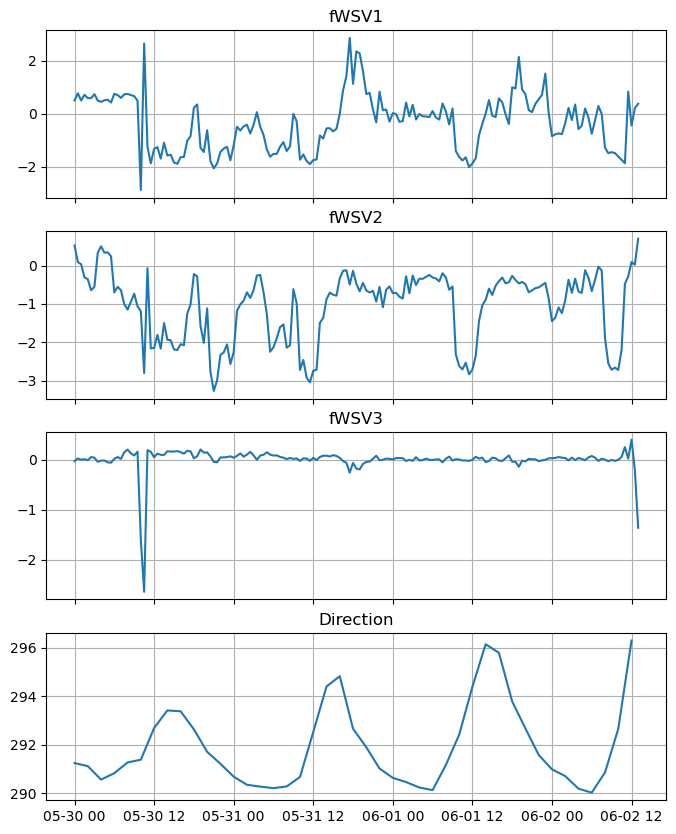

In [10]:
fig,ax=plt.subplots(ncols=1,nrows=4,figsize=(8,10),sharex=True)

ax[0].plot(ws_hhr.index,ws_hhr.fWSV1)
#ax[0].set_ylabel('Wind Speed') dunno
ax[0].set_title('fWSV1')

ax[1].plot(ws_hhr.index,ws_hhr.fWSV2)
ax[1].set_title('fWSV2')

ax[2].plot(ws_hhr.index,ws_hhr.fWSV3)
ax[2].set_title('fWSV3')

ax[3].plot(ws_2hr.index,ws_2hr.fWSC)
ax[3].set_title('Direction')

ax[0].grid(),ax[1].grid(),ax[2].grid(),ax[3].grid();

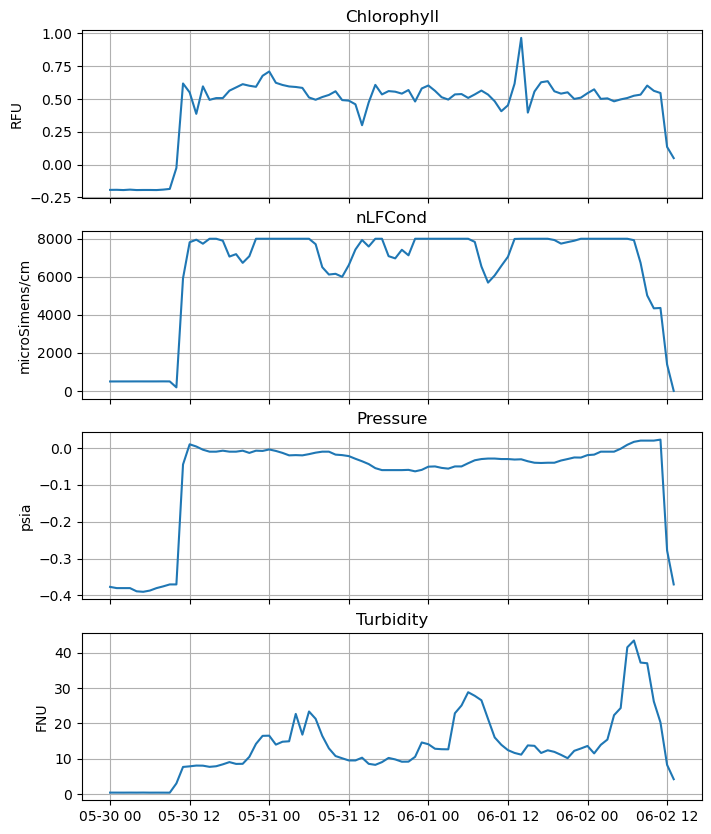

In [11]:
# only four for now, will do more later
fig,ax = plt.subplots(ncols=1,nrows=4,figsize=(8,10),sharex=True)

ax[0].plot(exo_hr.index,exo_hr.Chloro)
ax[0].set_ylabel('RFU')
ax[0].set_title('Chlorophyll')

ax[1].plot(exo_hr.index,exo_hr.nLFCond)
ax[1].set_ylabel('microSimens/cm')
ax[1].set_title('nLFCond')

ax[2].plot(exo_hr.index,exo_hr.Pressure)
ax[2].set_ylabel('psia')
ax[2].set_title('Pressure')

ax[3].plot(exo_hr.index,exo_hr.Turbidity)
ax[3].set_ylabel('FNU')
ax[3].set_title('Turbidity')

ax[0].grid(),ax[1].grid(),ax[2].grid(),ax[3].grid();

# These are things to plot
# Chloro (86,)
# nLFCond (86,)
# Pressure (86,)
# Turbidity (86,)
# Temp (86,)
# Cond (86,)
# D_OX (86,)
# Sal (86,)
# TSS (86,)
# VerticalPosition (86,)
# Depth (86,)
# D_OX2 (86,)
# SpCond (86,)
# WiperPosition (86,)
# BPower (86,)
# fDOM (86,)
# D_OX3 (86,)
# Phycoerythrin (86,)
# pH (86,)
# CablePower (86,)
# fDOM2 (86,)
# ORP (86,)
# TDS (86,)
# pH2 (86,)

In [225]:
# old something
# fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(8,5))
# ax[0].plot(dl_hr.index,dl_hr.PAR_aqua1_Tot)
# ax[0].set_ylabel('aqua1')
# ax[1].plot(dl2_hr.index,dl2_hr.PAR_aqua2_Tot)
# ax[1].set_ylabel('aqua2')

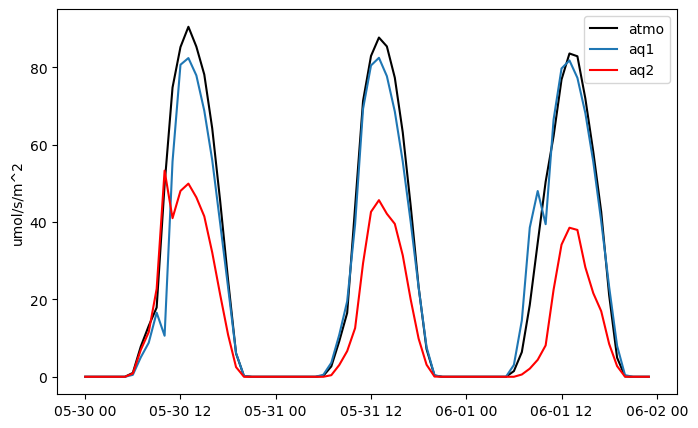

In [12]:
# plot three PAR sensors on same plot
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(paratmo_hr.index,paratmo_hr.PAR_atmo_Tot,label='atmo',color='black')
ax.plot(aqtop_hr.index,aqtop_hr.PAR_aqua1_Tot,label='aq1')
ax.plot(aqbottom_hr.index,aqbottom_hr.PAR_aqua2_Tot,label='aq2',color='red')
ax.set_ylabel('umol/s/m^2')
ax.legend();

<Axes: xlabel='time'>

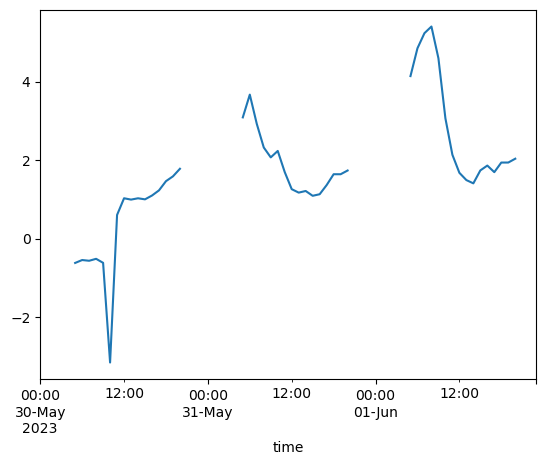

In [14]:
# this is not right
Lz = aqbottom_hr.PAR_aqua2_Den # deeper one 
Lo = aqtop_hr.PAR_aqua1_Den # upper one 
Z = 0.5

atten = -(np.log(Lz/Lo))/Z
atten.plot()

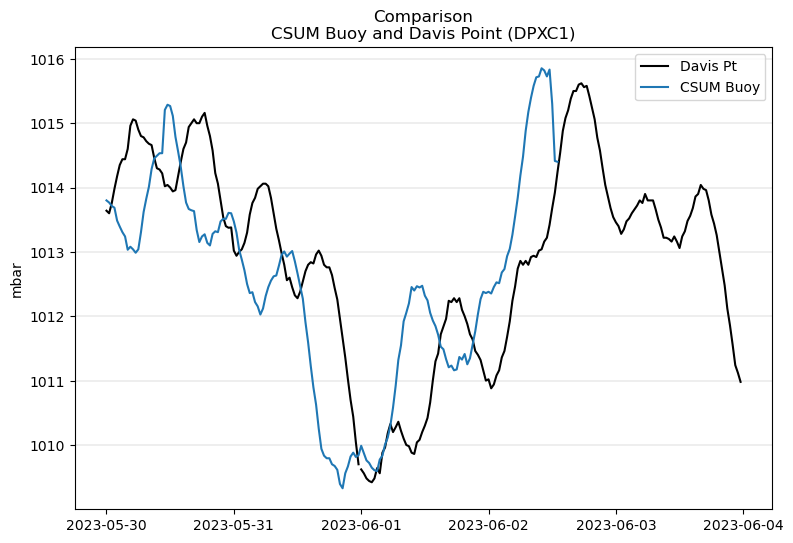

In [16]:
# compare data from Davis Point with the buoy
fig = plt.figure(figsize=(9,6))

plt.plot(davisjune_hhr.index,davisjune_hhr.PRES,color='k')
plt.plot(davismay_hhr.index,davismay_hhr.PRES,color='k',label='Davis Pt')
plt.plot(met_hhr.index,met_hhr.BP,label='CSUM Buoy')
plt.ylabel('mbar')
plt.grid(lw=0.3,axis='y')
plt.title('Comparison\nCSUM Buoy and Davis Point (DPXC1)')
plt.legend();

In [17]:
# use folium to show the buoy test location and Davis Point DPXC1

buoyloc = [38.066, -122.230]    # buoy location 38.06593137898257, -122.2301695546093
davisloc = [38.056, -122.264]   # Davis DPXC1 38.056 N, 122.264 W
mapcenter = [38.062, -122.247]  # define center of map

# if making a map users can zoom / pan
# min_lat, max_lat = 37.5,38.1    # define max lat so people don't get lost
# min_lon, max_lon = -122,-122.8  # as above for long

f = folium.Figure(width=200, height=200)

map = folium.Map( 
    location=mapcenter, 
    max_bounds=True,
    # min_lat=min_lat, # used in conjuction with above 
    # max_lat=max_lat,
    # min_lon=min_lon,
    # max_lon=max_lon,
    zoom_start=14.5,
    control_scale=False,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False)

# https://gis.stackexchange.com/questions/290861/python-folium-package-for-satellite-map
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = False
       ).add_to(map)

# marker for buoy
folium.Marker(buoyloc, popup="CSUM Buoy").add_to(map) # add buoy marker to map
folium.map.Marker(                                    # add text
    [38.066, -122.230],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(50,-20),
        html='<div style="color:#ffffff;font-size: 12pt">CSUM Buoy</div>',
        )
    ).add_to(map)

# marker for davis
folium.Marker(davisloc, popup="Davis Point DPXC1").add_to(map) # add Davis Pt DPXC1 marker to map
folium.map.Marker(                                             # add text
    [38.056, -122.264],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(25,-10),
        html='<div style="color:#ffffff;font-size: 12pt">DPXC1</div>',
        )
    ).add_to(map)

line_between = [
    (38.066, -122.230),
    (38.056, -122.264),
]

line=folium.PolyLine(
    locations=line_between,
    weight=3,
    color='#e02525'
    ).add_to(map)

#show the map
map